In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import cv2
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def display(array1, array2):
    
    n = 8

    indices = [i for i in range(n)]
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        image1 = image1.squeeze()
        image2 = image2.squeeze()
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(256,256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(256,256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# 先不讀取圖片, 真的要訓練才讀
# 只讀取路徑

df_path = pd.DataFrame(columns=["path"])
df_solution = pd.DataFrame(columns=["solution"])
df_predict = pd.DataFrame(columns=["path"])

for p in glob.glob("/content/gdrive/My Drive/project/image/*.png"):
    s = pd.Series([p], index=["path"])
    df_path = df_path.append(s, ignore_index=True)
for p in glob.glob("/content/gdrive/My Drive/project/solution/*.png"):
    s = pd.Series([p], index=["solution"])
    df_solution = df_solution.append(s, ignore_index=True)
for p in glob.glob("/content/gdrive/My Drive/project/test_img/*.png"):
    s = pd.Series([p], index=["path"])
    df_predict = df_predict.append(s, ignore_index=True)

# 將圖片按照照片編號牌好，而不是索引值
df_path = df_path.sort_values(by=['path'])
df_solution = df_solution.sort_values(by=['solution'])

print(df_path)
print(df_solution)
print(df_predict)

                                                 path
766  /content/gdrive/My Drive/project/image/00001.png
352  /content/gdrive/My Drive/project/image/00002.png
285  /content/gdrive/My Drive/project/image/00003.png
402  /content/gdrive/My Drive/project/image/00004.png
416  /content/gdrive/My Drive/project/image/00005.png
..                                                ...
23   /content/gdrive/My Drive/project/image/00996.png
522  /content/gdrive/My Drive/project/image/00997.png
121  /content/gdrive/My Drive/project/image/00998.png
611  /content/gdrive/My Drive/project/image/00999.png
721  /content/gdrive/My Drive/project/image/01000.png

[1000 rows x 1 columns]
                                              solution
301  /content/gdrive/My Drive/project/solution/0000...
769  /content/gdrive/My Drive/project/solution/0000...
950  /content/gdrive/My Drive/project/solution/0000...
734  /content/gdrive/My Drive/project/solution/0000...
165  /content/gdrive/My Drive/project/solution/0000.

In [ ]:
from sklearn.model_selection import train_test_split
# 真的要開始切分和訓練的時候, 再把pandas的資料轉成numpy的array
x_train, x_test, y_train, y_test = train_test_split(np.array(df_path["path"]),
                              np.array(df_solution["solution"]),
                              test_size=0.2)
x_predict = np.array(df_predict["path"])

In [ ]:
pic_size = 256
input = layers.Input(shape=(pic_size, pic_size, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 32)      9248  

In [ ]:
X_train = []
Y_train = []
for i, j in zip(x_train,y_train):
  X_train.append(cv2.resize(cv2.imread(i, cv2.IMREAD_GRAYSCALE), (pic_size,pic_size)))
  Y_train.append(cv2.resize(cv2.imread(j, cv2.IMREAD_GRAYSCALE), (pic_size,pic_size)))
X_train = np.reshape(X_train, [-1, pic_size, pic_size, 1])
Y_train = np.reshape(Y_train, [-1, pic_size, pic_size, 1])
X_train = X_train.astype('float32') / 255.0
Y_train = Y_train.astype('float32') / 255.0
print(X_train.shape)
print(Y_train.shape)

#---------------------------------------------------------------------------------------------------------#

X_test = []
Y_test = []
for i, j in zip(x_test,y_test):
  X_test.append(cv2.resize(cv2.imread(i, cv2.IMREAD_GRAYSCALE), (pic_size,pic_size)))
  Y_test.append(cv2.resize(cv2.imread(j, cv2.IMREAD_GRAYSCALE), (pic_size,pic_size)))
X_test = np.reshape(X_test, [-1, pic_size, pic_size, 1])
Y_test = np.reshape(Y_test, [-1, pic_size, pic_size, 1])
X_test = X_test.astype('float32') / 255.0
Y_test = Y_test.astype('float32') / 255.0
print(X_test.shape)
print(Y_test.shape)

#---------------------------------------------------------------------------------------------------------#

X_predict = []
for i in np.array(df_predict["path"]):
  X_predict.append(cv2.resize(cv2.imread(i, cv2.IMREAD_GRAYSCALE), (pic_size,pic_size)))
X_predict = np.reshape(X_predict, [-1, pic_size, pic_size, 1])
X_predict = X_predict.astype('float32') / 255.0
print(X_predict.shape)

(800, 256, 256, 1)
(800, 256, 256, 1)
(200, 256, 256, 1)
(200, 256, 256, 1)
(8, 256, 256, 1)


In [ ]:
history = autoencoder.fit( x = X_train,
                y = Y_train,
                epochs=300,
                batch_size=25,
                validation_data=(X_test, Y_test))

Epoch 1/300
32/32 [==============================] - 35s 100ms/step - loss: 0.4960 - val_loss: 0.2895
Epoch 2/300
32/32 [==============================] - 3s 95ms/step - loss: 0.1956 - val_loss: 0.1615
Epoch 3/300
32/32 [==============================] - 3s 95ms/step - loss: 0.1487 - val_loss: 0.1530
Epoch 4/300
32/32 [==============================] - 3s 95ms/step - loss: 0.1412 - val_loss: 0.1499
Epoch 5/300
32/32 [==============================] - 3s 96ms/step - loss: 0.1363 - val_loss: 0.1410
Epoch 6/300
32/32 [==============================] - 3s 95ms/step - loss: 0.1311 - val_loss: 0.1346
Epoch 7/300
32/32 [==============================] - 3s 96ms/step - loss: 0.1225 - val_loss: 0.1217
Epoch 8/300
32/32 [==============================] - 3s 96ms/step - loss: 0.1113 - val_loss: 0.1149
Epoch 9/300
32/32 [==============================] - 3s 96ms/step - loss: 0.1075 - val_loss: 0.1097
Epoch 10/300
32/32 [==============================] - 3s 97ms/step - loss: 0.1070 - val_loss: 0.10

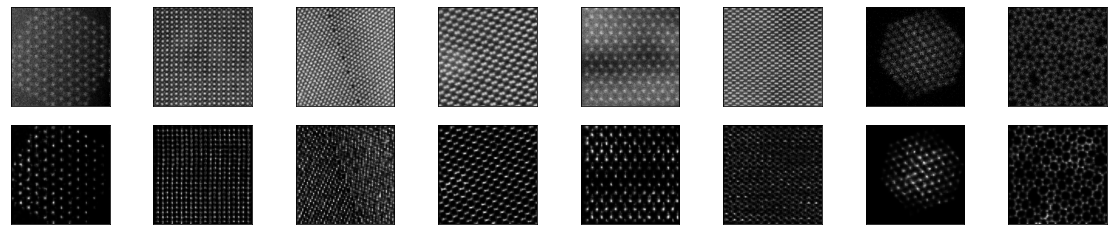

In [ ]:
Y_predict = autoencoder.predict(X_predict)
display(X_predict, Y_predict)

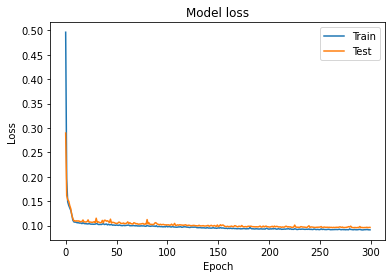

In [ ]:
# 繪製loss & val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()